In [1]:
import sys
import os
import glob
import shutil
import numpy as np
import cv2
import lmdb
import random

from matplotlib import pyplot as plt
from skimage import exposure
%matplotlib inline

In [2]:
sys.path.insert(0, '/home/nathan/caffe-segnet-crf/python')
import caffe
from caffe.proto import caffe_pb2

# Random crops

In [46]:
# Prostate Cancer images
# image_source = '/home/nathan/histo-seg/semantic-pca/data/source_training/jpg'
# mask_source = '/home/nathan/histo-seg/semantic-pca/data/source_training/mask'

# ccRCC images
image_source = '/home/nathan/histo-seg/semantic-ccrcc/data/source_img'
mask_source = '/home/nathan/histo-seg/semantic-ccrcc/data/source_mask'

'''
For rearranging the mask labels:
{original: new, original: new, etc.}
'''
# rearr = {3:0, 0:1, 1:1, 2:1, 4:1}
rearr = {29:0, 79:1, 94:2, 190:3, 255:3}

img_list = sorted(glob.glob(
    os.path.join(image_source, '*.tif')
))
mask_list = sorted(glob.glob(
    os.path.join(mask_source, '*.tif')
))

# Shuffle:
c = list(zip(img_list, mask_list))
random.shuffle(c)
img_list, mask_list = zip(*c)

print 'Found {} images in {}'.format(len(img_list), image_source)
print 'Found {} images in {}'.format(len(mask_list), mask_source)


# h,w = sampleimg.shape[:2]
# print h,w

winsize = 512
scale = 2
winwrite = winsize / scale
n = 20
border = 200

hlist = [cv2.imread(il).shape[0] for il in img_list]
r = lambda h: np.random.randint(h-winsize-border)+border
coords = [[(r(h), r(h)) for _ in range(n)] for h in hlist]


'''
Create an lmdb database of images

'''
# image_db = '/home/nathan/histo-seg/semantic-pca/data/db/feature_lmdb'
# mask_db = '/home/nathan/histo-seg/semantic-pca/data/db/mask_lmdb'
# mask_imgs = '/home/nathan/histo-seg/semantic-pca/data/debug_mask'
# debug_dir = '/home/nathan/histo-seg/semantic-pca/data/debug'

image_db = '/home/nathan/histo-seg/semantic-ccrcc/data/db/feature_lmdb'
mask_db = '/home/nathan/histo-seg/semantic-ccrcc/data/db/mask_lmdb'
mask_imgs = '/home/nathan/histo-seg/semantic-ccrcc/data/debug_mask'
debug_dir = '/home/nathan/histo-seg/semantic-ccrcc/data/debug'

# This block of logic so I don't have to keep redoing it.
if os.path.exists(image_db): print('Remaking {}'.format(image_db)); shutil.rmtree(image_db)
if os.path.exists(mask_db): print('Remaking {}'.format(mask_db));shutil.rmtree(mask_db)
if os.path.exists(debug_dir): print('Remaking {}'.format(debug_dir)); shutil.rmtree(debug_dir); os.mkdir(debug_dir)
if os.path.exists(mask_imgs): print('Remaking {}'.format(mask_imgs)); shutil.rmtree(mask_imgs); os.mkdir(mask_imgs)

if not os.path.exists(debug_dir): print('Making {}'.format(debug_dir)); os.mkdir(debug_dir)
if not os.path.exists(mask_imgs): print('Making {}'.format(mask_imgs)); os.mkdir(mask_imgs)

# Since we're cropping this is always going to be super adequate
safety = 5
sampleimg = cv2.imread(img_list[0])
est_total = sampleimg.nbytes * len(img_list) * n  # Number of crops instead.


'''
Write feature images (3-channel)
'''
env = lmdb.open(image_db, map_size=est_total)
index = 1
with env.begin(write=True) as txn:
    for k, (img_name, crops) in enumerate(zip(img_list, coords)):
        img = cv2.imread(img_name)
        
        for box in crops:
            x = box[0]
            y = box[1]
            subimg_ = img[x:x+winsize, y:y+winsize, :]
            subimg_ = cv2.resize(subimg_, dsize=(winwrite, winwrite))
            
            # From BVLC/caffe/issues/1698
            subimg = subimg_[:,:,::-1]
            subimg = subimg.transpose((2,0,1))
            
            datum = caffe.io.array_to_datum(subimg)
            str_id = '{:07}'.format(index)
            
            txn.put(str_id.encode('ascii'), datum.SerializeToString())
            if index % 500 == 0:
                print str_id
                cv2.imwrite(os.path.join(debug_dir, '{}t.png'.format(str_id)), 
                            subimg_)
            index += 1
            
print 'added {} files to {}'.format(index, image_db)
env.close()


'''
Write labels (1-channel)
'''
env = lmdb.open(mask_db, map_size=est_total)
index = 1
with env.begin(write=True) as txn:
    for k, (img_name, crops) in enumerate(zip(mask_list, coords)):
        img = cv2.imread(img_name, 0)
        
        '''
        Replace labels according to rearr dict
        '''
        img_copy = np.copy(img)
        for key in rearr.iterkeys():
            img_copy[img ==  key] = rearr[key]
        
        img = img_copy
        
        for box in crops:
            x = box[0]
            y = box[1]
            subimg_ = img[x:x+winsize, y:y+winsize]
            subimg_ = cv2.resize(subimg_, dsize=(winwrite, winwrite),
                                interpolation=cv2.INTER_NEAREST)
            subimg = np.expand_dims(subimg_, 0)  # (1, h, w)
            
            datum = caffe.io.array_to_datum(subimg)
            str_id = '{:07}'.format(index)
            
            txn.put(str_id.encode('ascii'), datum.SerializeToString())
            
            ### Only do this for test, or for small n
            cv2.imwrite(os.path.join(mask_imgs, '{}.png'.format(str_id)), subimg_)
            ###
            
            
            if index % 500 == 0:
                print str_id
                cv2.imwrite(os.path.join(debug_dir, '{}t_.png'.format(str_id)), 
                            subimg_*(255/subimg_.max()))
            index += 1
            
print 'added {} files to {}'.format(index, mask_db)
env.close()
print 'done'

Found 562 images in /home/nathan/histo-seg/semantic-pca/data/source_training/jpg
Found 562 images in /home/nathan/histo-seg/semantic-pca/data/source_training/mask
Remaking /home/nathan/histo-seg/semantic-pca/data/db/feature_lmdb
Remaking /home/nathan/histo-seg/semantic-pca/data/db/mask_lmdb
Remaking /home/nathan/histo-seg/semantic-pca/data/debug
Remaking /home/nathan/histo-seg/semantic-pca/data/debug_mask
0000500
0001000
0001500
0002000
0002500
0003000
0003500
0004000
0004500
0005000
0005500
0006000
0006500
0007000
0007500
0008000
0008500
0009000
0009500
0010000
0010500
0011000
added 11241 files to /home/nathan/histo-seg/semantic-pca/data/db/feature_lmdb
0000500


/home/nathan/.local/lib/python2.7/site-packages/ipykernel/__main__.py:137: RuntimeWarning: divide by zero encountered in divide


0001000
0001500
0002000
0002500
0003000
0003500
0004000
0004500
0005000
0005500
0006000
0006500
0007000
0007500
0008000
0008500
0009000
0009500
0010000
0010500
0011000
added 11241 files to /home/nathan/histo-seg/semantic-pca/data/db/mask_lmdb
done


# Check range and data type for images and masks

Found 130 images in /home/nathan/histo-seg/semantic-ccrcc/data/source_img
Found 130 images in /home/nathan/histo-seg/semantic-ccrcc/data/source_mask
Img /home/nathan/histo-seg/semantic-ccrcc/data/source_img/26_1_reg1.tif
Mask /home/nathan/histo-seg/semantic-ccrcc/data/source_mask/26_1_reg1.tif
Image dtpe:  uint8
Unique labels:  [0 1 2 3]
Label dtype:  uint8


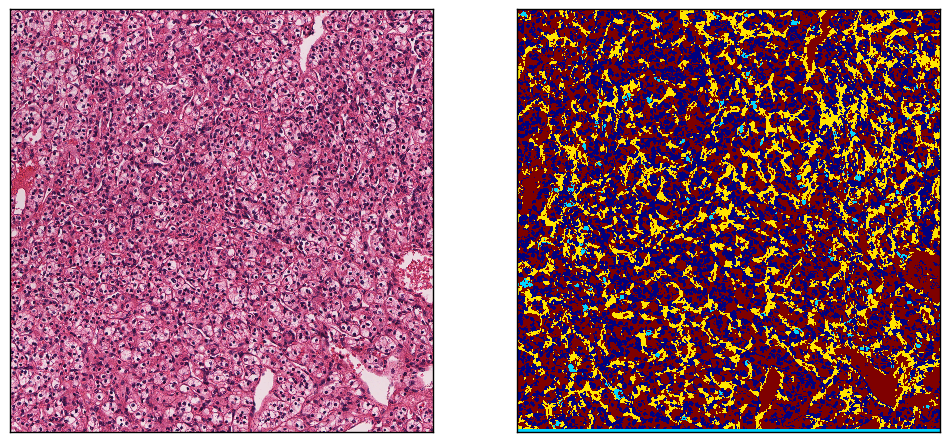

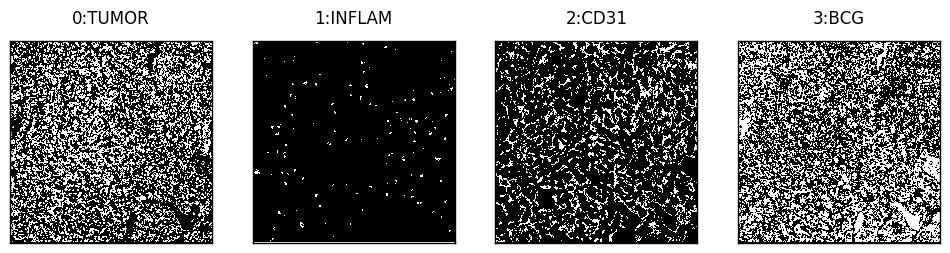

In [82]:
# Prostate Cancer images
# image_source = '/home/nathan/histo-seg/semantic-pca/data/source_training/jpg'
# mask_source = '/home/nathan/histo-seg/semantic-pca/data/source_training/mask'

# ccRCC images
image_source = '/home/nathan/histo-seg/semantic-ccrcc/data/source_img'
mask_source = '/home/nathan/histo-seg/semantic-ccrcc/data/source_mask'

# rearr = {3:0, 0:1, 1:1, 2:1, 4:1}
rearr = {29:0, 79:1, 94:2, 190:3, 255:3}
# rearr_str = {29:'tumor', 79:'inflam', 94:'cd31', 190:'bcg', 255:'bcg'}
rearr_str = {0:'TUMOR', 1:'INFLAM', 2:'CD31', 3:'BCG'}

img_list = sorted(glob.glob(
    os.path.join(image_source, '*.tif')
))
mask_list = sorted(glob.glob(
    os.path.join(mask_source, '*.tif')
))

c = list(zip(img_list, mask_list))
random.shuffle(c)
img_list, mask_list = zip(*c)


print 'Found {} images in {}'.format(len(img_list), image_source)
print 'Found {} images in {}'.format(len(mask_list), mask_source)

index = np.random.randint(len(mask_list))
print 'Img {}\nMask {}'.format(img_list[index], mask_list[index])
sampleimg = cv2.imread(img_list[index])
sampleimg = sampleimg[:,:,::-1]
samplemask = cv2.imread(mask_list[index], 0)

samplemask_copy = np.copy(samplemask)
for key in rearr.iterkeys():
    samplemask_copy[samplemask ==  key] = rearr[key]
samplemask = samplemask_copy

print 'Image dtpe: ',sampleimg.dtype
print 'Unique labels: ', np.unique(samplemask)
print 'Label dtype: ', samplemask.dtype

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(sampleimg);
ax[0].set_xticks([]); ax[0].set_yticks([])
ax[1].matshow(samplemask);
ax[1].set_xticks([]); ax[1].set_yticks([])

fig, ax = plt.subplots(1, len(np.unique(samplemask)), figsize=(12,4))
for a, u in zip(ax, np.unique(samplemask)):
    a.matshow(samplemask == u, cmap='gray')
    a.set_xticks([]); a.set_yticks([])
    a.set_title('{}:{}'.format(u, rearr_str[u]))
    

## If necessary do copy first

In [123]:
src = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1'
feature = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1_original'

feature_dest = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_feature_test'
outline_dest = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_outline_test'
mask_dest = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_mask_test'
label_dest = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_label_test'

src_list = sorted(glob.glob(
    os.path.join(src, '*.png')
))

feature_list = sorted(glob.glob(
    os.path.join(feature, '*.tif')
))

outline_list = [img for img in src_list if 'tif.png' in img]
mask_list = [img for img in src_list if '_mask' in img]
label_list = [img for img in src_list if 'Lmask' in img]

print feature_list[0]
print img_list[0]
print mask_list[0]
print label_list[0]

rep = lambda x: os.path.join(feature_dest, os.path.basename(x))
_ = [shutil.copyfile(img, rep(img)) for img in feature_list]
print 'Done copying originals'

rep = lambda x: os.path.join(outline_dest, os.path.basename(x.replace('.tif', '')))
_ = [shutil.copyfile(img, rep(img)) for img in img_list]
print 'Done copying outlines'

rep = lambda x: os.path.join(mask_dest, os.path.basename(x.replace('.tif_mask', '')))
_ = [shutil.copyfile(img, rep(img)) for img in mask_list]
print 'Done copying masks'

rep = lambda x: os.path.join(label_dest, os.path.basename(x.replace('.tif_Lmask', '')))
_ = [shutil.copyfile(img, rep(img)) for img in label_list]
print 'Done copying labels'

/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1_original/SP 02-4466 L3_001(5+5)_1_2.tif
/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_feature/SP 04-1514 1 L3_001(3+4)_2_4.tif
/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1/SP 02-4466 L3_001(5+5)_1_2.tif_mask.png
/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1/SP 02-4466 L3_001(5+5)_1_2.tif_Lmask.png
Done copying originals
Done copying outlines
Done copying masks
Done copying labels


In [45]:
help(caffe.io)

Help on module caffe.io in caffe:

NAME
    caffe.io

FILE
    /home/nathan/caffe-segnet-crf/python/caffe/io.py

CLASSES
    Transformer
    
    class Transformer
     |  Transform input for feeding into a Net.
     |  
     |  Note: this is mostly for illustrative purposes and it is likely better
     |  to define your own input preprocessing routine for your needs.
     |  
     |  Parameters
     |  ----------
     |  net : a Net for which the input should be prepared
     |  
     |  Methods defined here:
     |  
     |  __init__(self, inputs)
     |  
     |  deprocess(self, in_, data)
     |      Invert Caffe formatting; see preprocess().
     |  
     |  preprocess(self, in_, data)
     |      Format input for Caffe:
     |      - convert to single
     |      - resize to input dimensions (preserving number of channels)
     |      - transpose dimensions to K x H x W
     |      - reorder channels (for instance color to BGR)
     |      - scale raw input (e.g. from [0, 1] to [